In [1]:
import numpy as np
np.random.seed(2023)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
make_images = False

do_training = True

do_training_allzones = False

model_name = 'model_vae'

#n_rows, n_cols, n_channels = 9, 191, 1
n_rows, n_cols, n_channels = 9, 95, 1

original_dim = n_rows * n_cols

interm_dim = 200

latent_dim = 2

learning_rate = 0.01

batch_size = 256

epochs = 40

### Import data

In [3]:
if make_images:
  infile = '../test7/histos_tbf.1.npz'
  loaded = np.load(infile)
  out_part = loaded['out_part']
  out_hits = loaded['out_hits']

  print(out_part.shape, out_hits.shape)

### Find mean deflection angles

In [4]:
# Find 'quadstrip' unit
#PATTERN_X_SIZE = 48-1
#PATTERN_X_CENTRAL = 24-1
#PATTERN_X_DIV = 32

# Find 'dblstrip' unit
PATTERN_X_SIZE = 96-1
PATTERN_X_CENTRAL = 48-1
PATTERN_X_DIV = 16

# Find 'fullstrip' unit
#PATTERN_X_SIZE = 192-1
#PATTERN_X_CENTRAL = 96-1
#PATTERN_X_DIV = 8

PATTERN_X_SECTOR = 5400/PATTERN_X_DIV

nlayers = 16

nzones = 7

valid_layers = np.empty(nzones, dtype=np.object)
valid_layers[0] = [0,2,3,4,7,8,10,11]
valid_layers[1] = [0,2,3,4,7,8,9,10,11]
valid_layers[2] = [0,2,3,4,7,8,9,10]
valid_layers[3] = [0,2,3,4,7,8,9,10]
valid_layers[4] = [0,1,2,3,4,5,7,8,9]
valid_layers[5] = [1,2,3,4,5,6,7,8]
valid_layers[6] = [1,2,3,5,6,7,12,13,14]

layer_names = ['ME1/1', 'ME1/2', 'ME2', 'ME3', 'ME4',
               'RE1', 'RE2', 'RE3', 'RE4',
               'GE1/1', 'GE2/1', 'ME0',
               'MB1', 'MB2', 'MB3', 'MB4']
assert(len(layer_names) == nlayers)

ordered_layer_names = ['MB1', 'MB2', 'MB3', 'MB4',
                       'ME0', 'GE1/1', 'ME1/1',
                       'ME1/2', 'RE1',
                       'GE2/1', 'RE2', 'ME2',
                       'ME3', 'RE3',
                       'ME4', 'RE4']
assert(len(ordered_layer_names) == nlayers)

from six.moves import range, zip, map, filter

def _find_bin_fast(x, bins):
  x = np.clip(x, bins[1], bins[2]-1e-7)
  binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
  return binx.astype(np.int32)

def find_eta_bin_16(eta, bins=(16,0.8,2.4)):
  return _find_bin_fast(np.abs(eta), bins)

def find_pt_bin_100(pt, bins=(100,-0.5,0.5)):
  return _find_bin_fast(pt, bins)

_get_emtf_layer = lambda x: x[0]

_get_emtf_phi = lambda x: x[1]

In [5]:
patterns_match_me2 = np.zeros((100, 16, nlayers, PATTERN_X_SIZE), dtype=np.int32)
patterns_match_me3 = np.zeros((100, 16, nlayers, PATTERN_X_SIZE), dtype=np.int32)

def analysis(verbose=1):

  def _find_dphi():
    dphi = np.float32(0)
    dphi += (hit_phi1 - hit_phi2)
    #dphi /= (np.sinh(1.8587) / np.sinh(np.abs(part_eta)))
    dphi /= PATTERN_X_DIV
    dphi = np.round(dphi)
    return dphi.astype(np.int32)

  # Loop over part and hits
  # - part is (part_invpt, part_eta, part_phi, part_d0, zone, endsec, mode)
  # - hits is a fixed-size collection of (emtf_layer, emtf_phi) with size=50. 
  #   Invalid hits have emtf_layer=99

  ievt = 0

  for part, hits in zip(out_part, out_hits):
    if verbose and (ievt % 100000 == 0):  print("Processing event: {0}".format(ievt))

    (part_invpt, part_eta, part_phi, part_d0, zone, endsec, mode) = part
    zone, endsec = int(round(zone)), int(round(endsec))
    hits = hits[hits[:,0] != -99]  # valid hits only

    ipt100 = find_pt_bin_100(part_invpt)
    ieta16 = find_eta_bin_16(part_eta)

    amap = {}  # emtf_layer -> hits

    for ihit, hit in enumerate(hits):
      amap.setdefault(_get_emtf_layer(hit), []).append(hit)

    for k, v in amap.iteritems():
      n = len(v)
      amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer

    # Make pair of hits
    for k, v in amap.iteritems():
      emtf_layer = k
      hit1 = v
      hit_phi1 = _get_emtf_phi(hit1)

      # w.r.t ME2
      emtf_layer_me2 = 2
      hit2 = amap.get(emtf_layer_me2, None)
      if hit2 is not None:
        hit_phi2 = _get_emtf_phi(hit2)
        dphi = _find_dphi()
        dphi = np.clip(dphi, -PATTERN_X_CENTRAL, PATTERN_X_CENTRAL)
        ind = (ipt100, ieta16, emtf_layer, dphi+PATTERN_X_CENTRAL)
        patterns_match_me2[ind] += 1

        # Debug
        if ievt < 10:
          print ievt, part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi

      # w.r.t ME3
      emtf_layer_me3 = 3
      hit2 = amap.get(emtf_layer_me3, None)
      if hit2 is not None:
        hit_phi2 = _get_emtf_phi(hit2)
        dphi = _find_dphi()
        dphi = np.clip(dphi, -PATTERN_X_CENTRAL, PATTERN_X_CENTRAL)
        ind = (ipt100, ieta16, emtf_layer, dphi+PATTERN_X_CENTRAL)
        patterns_match_me3[ind] += 1

    ievt += 1
    # end loop over part and hits

  if verbose: print "DONE"
  return

In [6]:
%%time

if make_images:
  # Run analysis
  analysis()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


In [7]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# https://matplotlib.org/users/dflt_style_changes.html#colors-in-default-property-cycle
# https://github.com/vega/vega/wiki/Scales#scale-range-literals
category10_palette  = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')
category20_palette  = ('#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5')
category10a_palette = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5')

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

In [8]:
if make_images:
  # Make probability
  patterns_match_me2_1 = patterns_match_me2.astype(np.float32)
  patterns_match_me3_1 = patterns_match_me3.astype(np.float32)

  # Fix issues due to gap between ME2/1 & ME2/2 at eta=1.6
  # eta 1.5-1.6 -> 7
  # eta 1.6-1.7 -> 8
  patterns_match_me2_1[:,6,:,:] += patterns_match_me2[:,7,:,:]
  patterns_match_me2_1[:,7,:,:] += patterns_match_me2[:,6,:,:]
  patterns_match_me2_1[:,8,:,:] += patterns_match_me2[:,9,:,:]
  patterns_match_me2_1[:,9,:,:] += patterns_match_me2[:,8,:,:]

  # Fix issues due to gap between ME3/1 & ME3/2 at eta=1.7
  # eta 1.6-1.7 -> 8
  # eta 1.7-1.8 -> 9
  patterns_match_me3_1[:,7,:,:] += patterns_match_me3[:,8,:,:]
  patterns_match_me3_1[:,8,:,:] += patterns_match_me3[:,7,:,:]
  patterns_match_me3_1[:,9,:,:] += patterns_match_me3[:,10,:,:]
  patterns_match_me3_1[:,10,:,:] += patterns_match_me3[:,9,:,:]

  # Normalize
  patterns_match_me2_1_sum = patterns_match_me2_1.sum(axis=-1, keepdims=True)
  patterns_match_me3_1_sum = patterns_match_me3_1.sum(axis=-1, keepdims=True)
  patterns_match_me2_1[(patterns_match_me2_1_sum < 100)[...,0]] = 0
  patterns_match_me3_1[(patterns_match_me3_1_sum < 100)[...,0]] = 0
  patterns_match_me2_1_sum[patterns_match_me2_1_sum == 0] = 1
  patterns_match_me3_1_sum[patterns_match_me3_1_sum == 0] = 1
  patterns_match_me2_1 /= patterns_match_me2_1_sum
  patterns_match_me3_1 /= patterns_match_me3_1_sum

  # Add up the probabilities, and reverse dphi
  #patterns_match_me2_2 = 0.5 * (patterns_match_me2_1 + patterns_match_me3_1)[::-1]
  patterns_match_me2_2 = 0.25 * (3*patterns_match_me2_1 + 1*patterns_match_me3_1)[::-1]

  # Sanity check
  print patterns_match_me2_1[50,:,3].sum(axis=-1)
  print patterns_match_me3_1[50,:,2].sum(axis=-1)
  print patterns_match_me2_2[50,:,3].sum(axis=-1)

In [9]:
if make_images:
  # w.r.t ME2
  fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(6,6), sharex=True, sharey=True)

  for i in xrange(nlayers):
    for j in xrange(16):  # ieta16
      yy = np.zeros(100, dtype=np.float32) + PATTERN_X_CENTRAL
      for k in xrange(100):  # ipt100
        if patterns_match_me2_1[k,j,i].sum() > 0:
          yy[k] = np.searchsorted(patterns_match_me2_1[k,j,i].cumsum(), 0.5)  # median
      ax = axs[i/4,i%4]
      ax.plot(np.arange(len(yy))+0.5, yy-PATTERN_X_CENTRAL, color=category10a_palette[j])
      ax.set_ylim(-50,50)

  plt.show()

In [10]:
if make_images:
  # w.r.t ME3
  fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(6,6), sharex=True, sharey=True)

  for i in xrange(nlayers):
    for j in xrange(16):  # ieta16
      yy = np.zeros(100, dtype=np.float32) + PATTERN_X_CENTRAL
      for k in xrange(100):  # ipt100
        if patterns_match_me3_1[k,j,i].sum() > 0:
          yy[k] = np.searchsorted(patterns_match_me3_1[k,j,i].cumsum(), 0.5)  # median
      ax = axs[i/4,i%4]
      ax.plot(np.arange(len(yy))+0.5, yy-PATTERN_X_CENTRAL, color=category10a_palette[j])
      ax.set_ylim(-50,50)

  plt.show()

### Find patterns

In [11]:
images = np.empty(nzones, dtype=np.object)
labels = np.empty(nzones, dtype=np.object)
for ind in np.ndindex(images.shape):
  images[ind] = []
  labels[ind] = []

def analysis2(verbose=1):

  def _find_dphi():
    dphi = np.float32(0)
    dphi += (hit_phi1 - hit_phi2)
    #dphi /= (np.sinh(1.8587) / np.sinh(np.abs(part_eta)))
    dphi /= PATTERN_X_DIV
    dphi = np.round(dphi)
    return dphi.astype(np.int32)

  # Loop over part and hits
  # - part is (part_invpt, part_eta, part_phi, part_d0, zone, endsec, mode)
  # - hits is a fixed-size collection of (emtf_layer, emtf_phi) with size=50. 
  #   Invalid hits have emtf_layer=99

  ievt = 0

  for part, hits in zip(out_part, out_hits):
    if verbose and (ievt % 100000 == 0):  print("Processing event: {0}".format(ievt))

    (part_invpt, part_eta, part_phi, part_d0, zone, endsec, mode) = part
    zone, endsec = int(round(zone)), int(round(endsec))
    hits = hits[hits[:,0] != -99]  # valid hits only

    ipt100 = find_pt_bin_100(part_invpt)
    ieta16 = find_eta_bin_16(part_eta)

    # Part I - find keystrip
    yy = np.zeros(PATTERN_X_SECTOR, dtype=np.float32)

    for ihit, hit in enumerate(hits):
      emtf_layer = _get_emtf_layer(hit)
      hit_phi1 = _get_emtf_phi(hit)
      hit_phi2 = 0
      dphi = _find_dphi()

      likelihood = patterns_match_me2_2[ipt100, ieta16, emtf_layer]

      ind1 = dphi-PATTERN_X_CENTRAL
      ind2 = dphi+PATTERN_X_CENTRAL+1
      if (dphi-PATTERN_X_CENTRAL) < 0:
        ind1 = -(dphi-PATTERN_X_CENTRAL)
        yy[:ind2] += likelihood[ind1:]
      elif (dphi+PATTERN_X_CENTRAL+1) > PATTERN_X_SECTOR:
        ind2 = -(dphi+PATTERN_X_CENTRAL+1) + PATTERN_X_SECTOR
        yy[ind1:] += likelihood[:ind2]
      else:
        yy[ind1:ind2] += likelihood

      # Debug
      if ievt < 10:
        print ievt, part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi, np.argmax(likelihood)-PATTERN_X_CENTRAL

    keystrip = np.argmax(yy)  # max likelihood

    # Part II - make image
    img0 = np.zeros((nlayers, PATTERN_X_SIZE), dtype=np.bool)
    img1 = np.zeros((nlayers, PATTERN_X_SIZE), dtype=np.bool)  # mirror

    for ihit, hit in enumerate(hits):
      emtf_layer = _get_emtf_layer(hit)
      hit_phi1 = _get_emtf_phi(hit)
      hit_phi2 = 0
      dphi = _find_dphi()

      row = emtf_layer
      col = (dphi - keystrip)
      if -PATTERN_X_CENTRAL <= col <= PATTERN_X_CENTRAL:
        img0[row, +col+PATTERN_X_CENTRAL] = 1
        img1[row, -col+PATTERN_X_CENTRAL] = 1

      # Debug
      if ievt < 10:
        print '..', part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi, keystrip, col

    images[zone].append(img0)
    labels[zone].append(+part_invpt)
    images[zone].append(img1)
    labels[zone].append(-part_invpt)
    
    ievt += 1
    # end loop over part and hits

  if verbose: print "DONE"
  return

In [12]:
%%time

if make_images:
  # Run analysis
  analysis2()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


In [13]:
if make_images:
  for zone in xrange(nzones):
    images[zone] = np.asarray(images[zone])
    labels[zone] = np.asarray(labels[zone])

  outfile = 'myimages_out.npz'
  d1 = {('images_zone%i' % zone): images[zone] for zone in xrange(nzones)}
  d2 = {('labels_zone%i' % zone): labels[zone] for zone in xrange(nzones)}
  d1.update(d2)
  np.savez_compressed(outfile, **d1)

In [14]:
if not make_images:
  infile = 'myimages_out.1.npz'
  with np.load(infile) as loaded:
    #for zone in xrange(nzones):
    #  images[zone]=loaded['images_zone%i' % zone]
    #  labels[zone]=loaded['labels_zone%i' % zone]
    for zone in [1]:
      images[zone]=loaded['images_zone%i' % zone]
      labels[zone]=loaded['labels_zone%i' % zone]

### Training

In [15]:
import os
import sys
os.environ['KERAS_BACKEND'] = 'tensorflow'

import tensorflow as tf

import keras
from keras import backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [16]:
from sklearn.model_selection import train_test_split

def load_dataset():
  zimages = images[zone]
  zlabels = labels[zone]
  zlayers = sorted(valid_layers[zone], key=lambda x: ordered_layer_names.index(layer_names[x]))
  
  # Hack to make n_rows == 9
  while len(zlayers) < 9:
    zlayers += [15]  # MB4 layer is always empty

  zimages = zimages[:, zlayers]
  zimages = zimages[:,:,:,np.newaxis]
  zimages = zimages.astype(np.float32)
  print(zimages.shape, zimages.dtype, zlabels.shape, zlabels.dtype)
  assert(original_dim == zimages.shape[1] * zimages.shape[2])

  x_train, x_test, y_train, y_test = train_test_split(zimages, zlabels, test_size=0.5)
  x_train = np.reshape(x_train, [-1, original_dim])
  x_test = np.reshape(x_test, [-1, original_dim])
  print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
  return x_train, x_test, y_train, y_test

In [17]:
# Draw the first 9 images and the average of all images
def draw_images():
  fig, axs = plt.subplots(3, 3, figsize=(4.5,4.5), sharex=True, sharey=True)
  for i in xrange(9):
    img = x_train[i]
    img = img.reshape((n_rows, n_cols))
    ax = axs[i/3,i%3]
    ax.imshow(img, origin='lower', interpolation='nearest', aspect='auto',
              cmap=blue_hot, vmin=0, vmax=1.8, alpha=.9)
    ax.axis('off')

  from matplotlib.colors import LogNorm
  my_cmap = plt.cm.viridis
  vmin = 1e-3
  my_cmap.set_under('w',vmin)

  img = (x_train.sum(axis=0)) + (x_test.sum(axis=0))
  img = img.reshape((n_rows, n_cols))
  print (x_train.shape[0] + x_test.shape[0]), img.min(), img.max()
  img /= img.max()

  fig, ax = plt.subplots(1, 1, figsize=(4.5,4.5))
  im = ax.imshow(img, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=my_cmap, vmin=vmin, norm=LogNorm(vmin=vmin, vmax=1))
  plt.colorbar(im)
  plt.show()

In [18]:
# Codes taken from
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
  """Reparameterization trick by sampling from an isotropic unit Gaussian.
  # Arguments
      args (tensor): mean and log of variance of Q(z|X)
  # Returns
      z (tensor): sampled latent vector
  """
  z_mean, z_log_var = args
  batch = K.shape(z_mean)[0]
  dim = K.int_shape(z_mean)[1]
  # by default, random_normal has mean = 0 and std = 1.0
  epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

def hard_sigmoid(x):
  return K.clip((x+1.)/2.,0,1)

def relu6(x):
  return K.relu(x, alpha=0., max_value=6, threshold=0.)

In [19]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import json

def create_model(original_dim=784, interm_dim=256, latent_dim=2, learning_rate=0.001):
  # VAE model = encoder + decoder
  # build encoder model
  input_shape = (original_dim, )
  inputs = Input(shape=input_shape, name='encoder_input')
  x = Dense(interm_dim, activation='relu')(inputs)
  z_mean = Dense(latent_dim, name='z_mean')(x)
  z_log_var = Dense(latent_dim, name='z_log_var')(x)

  # use reparameterization trick to push the sampling out as input
  # note that "output_shape" isn't necessary with the TensorFlow backend
  z = Lambda(sampling, name='z')([z_mean, z_log_var])

  # instantiate encoder model
  encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
  encoder.summary()
  display_model(encoder, show_shapes=True)

  # build decoder model
  latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
  x = Dense(interm_dim, activation='relu')(latent_inputs)
  outputs = Dense(original_dim, activation='sigmoid')(x)
  #outputs = Dense(original_dim, activation=hard_sigmoid)(x)

  # instantiate decoder model
  decoder = Model(latent_inputs, outputs, name='decoder')
  decoder.summary()
  display_model(decoder, show_shapes=True)

  # instantiate VAE model
  model_outputs = decoder(encoder(inputs)[2])
  model = Model(inputs, model_outputs, name='vae_mlp')

  # calculate VAE loss
  # [note: 
  #    def binary_crossentropy(y_true, y_pred):
  #      return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
  # ]
  reconstruction_loss = binary_crossentropy(inputs, model_outputs)
  reconstruction_loss *= original_dim
  kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  model_loss = K.mean(reconstruction_loss + kl_loss)
  model.add_loss(model_loss)

  adam = Adam(lr=learning_rate)
  model.compile(optimizer=adam, loss=None,
                metrics=[binary_crossentropy])
  model.summary()
  display_model(model, show_shapes=True)
  return encoder, decoder, model

def save_my_model(model, name='model'):
  # Store model to file
  #model.summary()
  model.save(name + '.h5')
  model.save_weights(name + '_weights.h5')
  # Store model to json
  with open(name + '.json', 'w') as outfile:
    outfile.write(model.to_json())
  return

def load_my_model(name='model.json', weights_name='model_weights.h5'):
  with open(name, 'r') as f:
    json_string = json.dumps(json.load(f))
    model = model_from_json(json_string)
  model.load_weights(weights_name)
  return model

def get_model_name():
  return model_name + ('_zone%i' % zone)

def get_model_name_enc():
  return model_name + ('_zone%i' % zone) + '_enc'

def get_model_name_dec():
  return model_name + ('_zone%i' % zone) + '_dec'

def display_model(model,
                  show_shapes=False,
                  show_layer_names=True,
                  rankdir='TB'):
  """Display a Keras model
    # Arguments
        model: A Keras model instance
        show_shapes: whether to display shape information.
        show_layer_names: whether to display layer names.
        rankdir: `rankdir` argument passed to PyDot,
            a string specifying the format of the plot:
            'TB' creates a vertical plot;
            'LR' creates a horizontal plot.
  """
  import pydot
  from keras.utils.vis_utils import model_to_dot
  dot = model_to_dot(model, show_shapes, show_layer_names, rankdir)
  
  from IPython.display import SVG, display
  display(SVG(dot.create_svg()))
  return

((606388, 9, 95, 1), dtype('float32'), (606388,), dtype('float32'))
((303194, 855), (303194, 855), (303194,), (303194,))
606388 0.0 465082.0


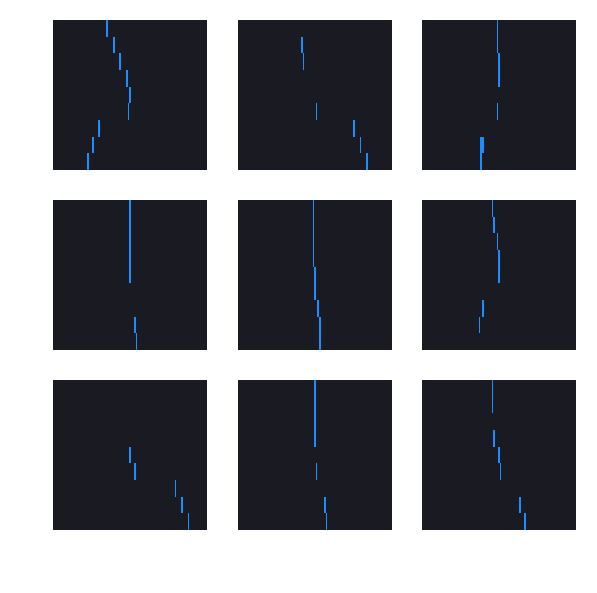

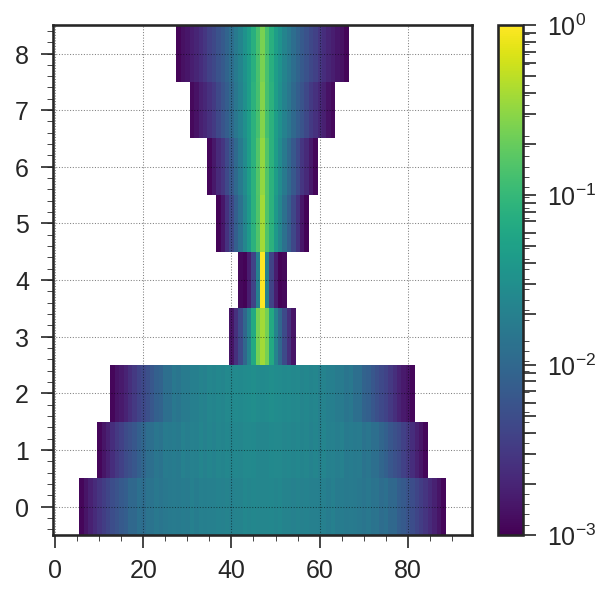

In [20]:
# Zone 1
zone = 1

# load dataset
x_train, x_test, y_train, y_test = load_dataset()

# draw images
draw_images()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 855)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          171200      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            402         dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            402         dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

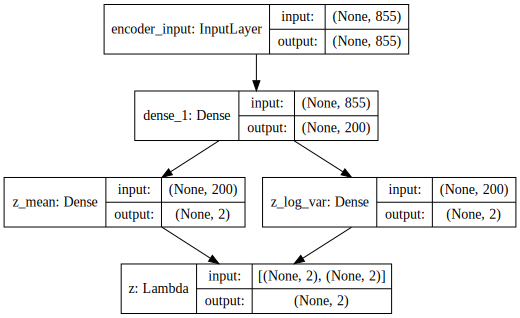

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_3 (Dense)              (None, 855)               171855    
Total params: 172,455
Trainable params: 172,455
Non-trainable params: 0
_________________________________________________________________


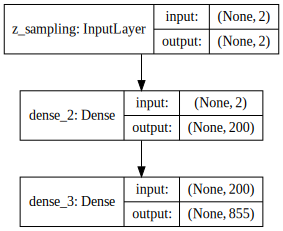

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 855)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 172004    
_________________________________________________________________
decoder (Model)              (None, 855)               172455    
Total params: 344,459
Trainable params: 344,459
Non-trainable params: 0
_________________________________________________________________


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:55: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.


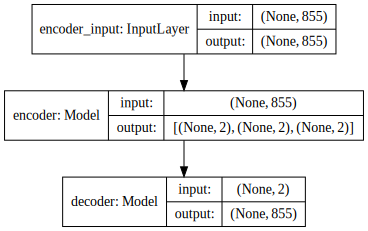

Train on 303194 samples, validate on 303194 samples
Epoch 1/40
303194/303194 [==============================] - 39s 130us/step - loss: 27.3111 - val_loss: 23.3149
Epoch 2/40
303194/303194 [==============================] - 37s 124us/step - loss: 22.9034 - val_loss: 22.4801
Epoch 3/40
303194/303194 [==============================] - 38s 124us/step - loss: 22.1953 - val_loss: 21.9048
Epoch 4/40
303194/303194 [==============================] - 37s 123us/step - loss: 21.7389 - val_loss: 21.5258
Epoch 5/40
303194/303194 [==============================] - 38s 124us/step - loss: 21.3886 - val_loss: 21.2653
Epoch 6/40
303194/303194 [==============================] - 38s 124us/step - loss: 21.0980 - val_loss: 20.9590
Epoch 7/40
303194/303194 [==============================] - 37s 123us/step - loss: 20.8784 - val_loss: 20.8699
Epoch 8/40
303194/303194 [==============================] - 37s 123us/step - loss: 20.7265 - val_loss: 20.7215
Epoch 9/40
303194/303194 [==============================] - 

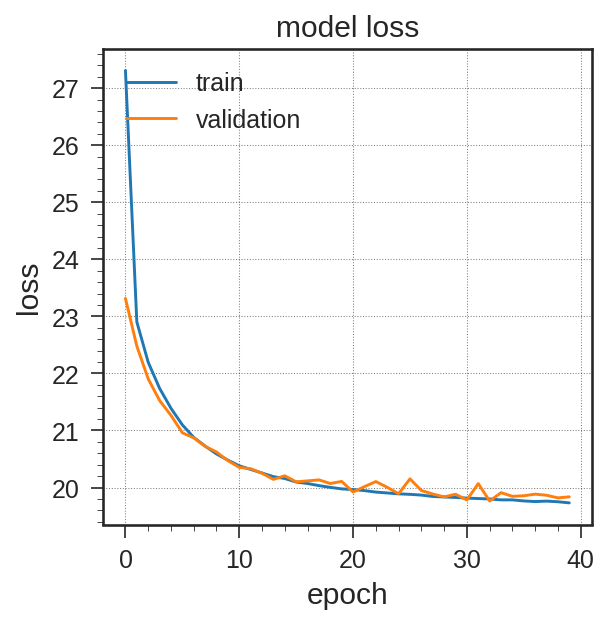

In [21]:
if do_training:
  # create model
  encoder, decoder, model = create_model(original_dim=original_dim, interm_dim=interm_dim, latent_dim=latent_dim,
                                         learning_rate=learning_rate)

  # train model
  history = model.fit(x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, None))
  
  # save model
  save_my_model(model, get_model_name())
  save_my_model(encoder, get_model_name_enc())
  save_my_model(decoder, get_model_name_dec())
  
  # plot training history
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Application

In [22]:
def plot_results(submodels,
                 data,
                 batch_size=128,
                 n_rows=28,
                 n_cols=28,
                 model_name="vae_mnist"):
  """Plots labels and MNIST digits as a function of the 2D latent vector
  # Arguments
      submodels (tuple): encoder and decoder models
      data (tuple): test data and label
      batch_size (int): prediction batch size
      model_name (string): which model is using this function
  """
  encoder, decoder = submodels
  x_test, y_test = data
  if not os.path.exists("keras_plots/" + model_name):
    os.makedirs("keras_plots/" + model_name)

  filename = os.path.join("keras_plots/" + model_name, "vae_mean.png")
  # display a 2D plot of the digit classes in the latent space
  z_mean, _, _ = encoder.predict(x_test, batch_size=1024)
  plt.figure(figsize=(10, 8))
  if latent_dim == 2:
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
  elif latent_dim == 1:
    plt.scatter(z_mean[:, 0], np.random.randn(z_mean.shape[0]), c=y_test)
  else:
    raise Exception('Unexpected latent_dim: %i' % latent_dim)
  plt.colorbar()
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.savefig(filename)
  plt.show()
  
  if latent_dim == 2:
    filename = os.path.join("keras_plots/" + model_name, "labal_vs_latent_0.png")
    plt.figure(figsize=(4, 4))
    plt.hist2d(np.arctan2(z_mean[:, 1], z_mean[:, 0]), y_test, bins=(100,100), range=((-4,4),(-0.5,0.5)))
    plt.xlabel("z[0]")
    plt.ylabel("label")
    plt.savefig(filename)
    plt.show()
    filename = os.path.join("keras_plots/" + model_name, "labal_vs_latent_0.png")
    plt.figure(figsize=(4, 4))
    plt.hist2d(np.hypot(z_mean[:, 0], z_mean[:, 1]), y_test, bins=(100,100), range=((-4,4),(-0.5,0.5)))
    plt.xlabel("z[1]")
    plt.ylabel("label")
    plt.savefig(filename)
    plt.show()
  elif latent_dim == 1:
    filename = os.path.join("keras_plots/" + model_name, "labal_vs_latent_0.png")
    plt.figure(figsize=(4, 4))
    plt.hist2d(z_mean[:, 0], y_test, bins=(100,100), range=((-4,4),(-0.5,0.5)))
    plt.xlabel("z[0]")
    plt.ylabel("label")
    plt.savefig(filename)
    plt.show()
  else:
    raise Exception('Unexpected latent_dim: %i' % latent_dim)

  filename = os.path.join("keras_plots/" + model_name, "digits_over_latent.png")
  # display a 30x30 2D manifold of digits
  n = 30
  #digit_size=28,
  #figure = np.zeros((digit_size * n, digit_size * n))
  figure = np.zeros((n_rows * n, n_cols * n))
  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-4, 4, n)
  grid_y = np.linspace(-4, 4, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      if latent_dim == 2:
        z_sample = np.array([[xi, yi]])
      elif latent_dim == 1:
        z_sample = np.array([xi])
      else:
        raise Exception('Unexpected latent_dim: %i' % latent_dim)
      x_decoded = decoder.predict(z_sample)
      #digit = x_decoded[0].reshape(digit_size, digit_size)
      #figure[i * digit_size: (i + 1) * digit_size,
      #       j * digit_size: (j + 1) * digit_size] = digit
      digit = x_decoded[0].reshape(n_rows, n_cols)
      figure[i * n_rows: (i + 1) * n_rows,
             j * n_cols: (j + 1) * n_cols] = digit


  plt.figure(figsize=(8, 8))
  #start_range = digit_size // 2
  #end_range = n * digit_size + start_range + 1
  #pixel_range = np.arange(start_range, end_range, digit_size)
  #sample_range_x = np.round(grid_x, 1)
  #sample_range_y = np.round(grid_y, 1)
  #plt.xticks(pixel_range, sample_range_x)
  #plt.yticks(pixel_range, sample_range_y)
  plt.xticks([])
  plt.yticks([])

  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, aspect='auto', 
             cmap=blue_hot, vmin=0, vmax=1.8, alpha=.9)
  plt.savefig(filename)
  plt.show()

In [23]:
def draw_generated_images():
  encoder, decoder = submodels

  n = x_train.shape[0] + x_test.shape[0]
  if latent_dim == 2:
    z_samples = np.random.randn(n, 2)
  elif latent_dim == 1:
    z_samples = np.random.randn(n)
  else:
    raise Exception('Unexpected latent_dim: %i' % latent_dim)
  x_decoded = decoder.predict(z_samples, batch_size=1024)

  from matplotlib.colors import LogNorm
  my_cmap = plt.cm.viridis
  vmin = 1e-3
  my_cmap.set_under('w',vmin)

  img = x_decoded.sum(axis=0)
  img = img.reshape((n_rows, n_cols))
  print x_decoded.shape[0], img.min(), img.max()
  img /= img.max()

  fig, ax = plt.subplots(1, 1, figsize=(4.5,4.5))
  im = ax.imshow(img, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=my_cmap, vmin=vmin, norm=LogNorm(vmin=vmin, vmax=1))
  plt.colorbar(im)
  plt.show()

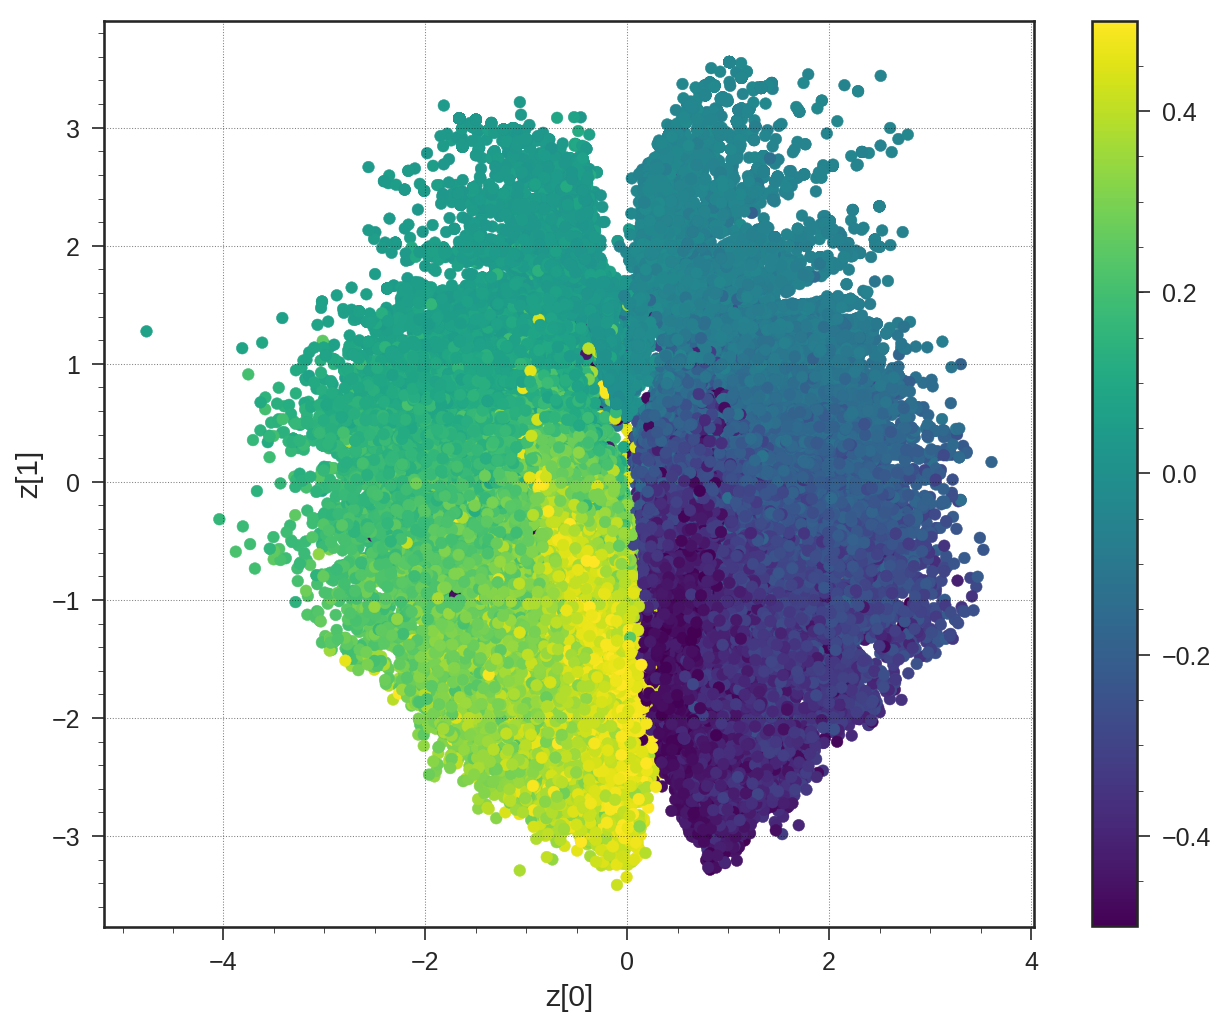

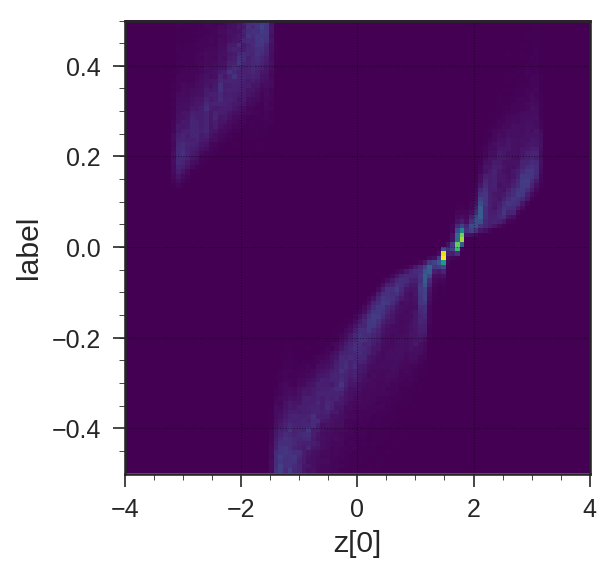

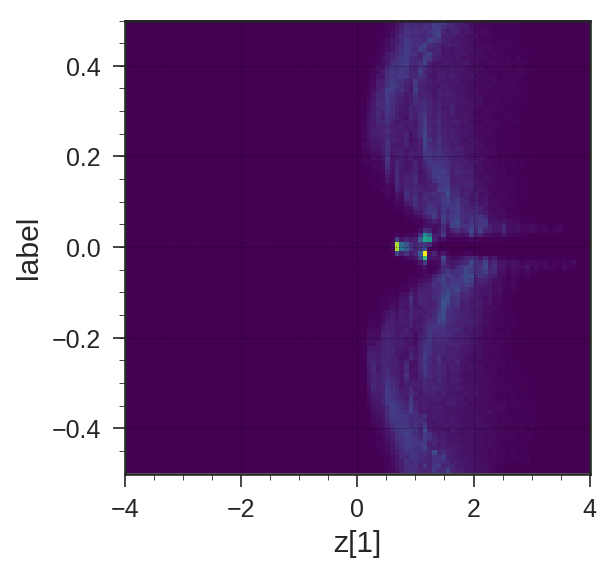

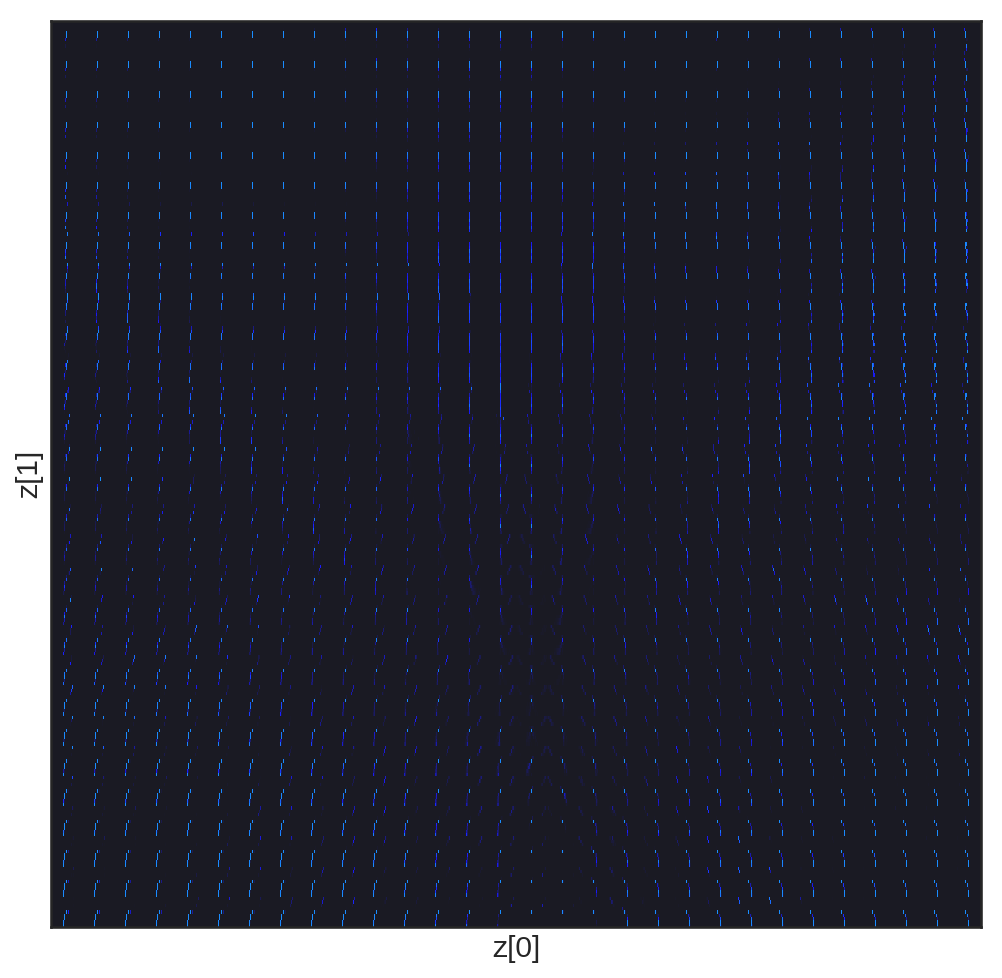

In [24]:
# plot results
loaded_model = load_my_model(name=get_model_name()+'.json', weights_name=get_model_name()+'_weights.h5')
loaded_encoder = load_my_model(name=get_model_name_enc()+'.json', weights_name=get_model_name_enc()+'_weights.h5')
loaded_decoder = load_my_model(name=get_model_name_dec()+'.json', weights_name=get_model_name_dec()+'_weights.h5')

#submodels = (encoder, decoder)
submodels = (loaded_encoder, loaded_decoder)
data = (x_test, y_test)
plot_results(submodels, data, n_rows=n_rows, n_cols=n_cols, model_name=get_model_name())

606388 0.0014840772 448247.3


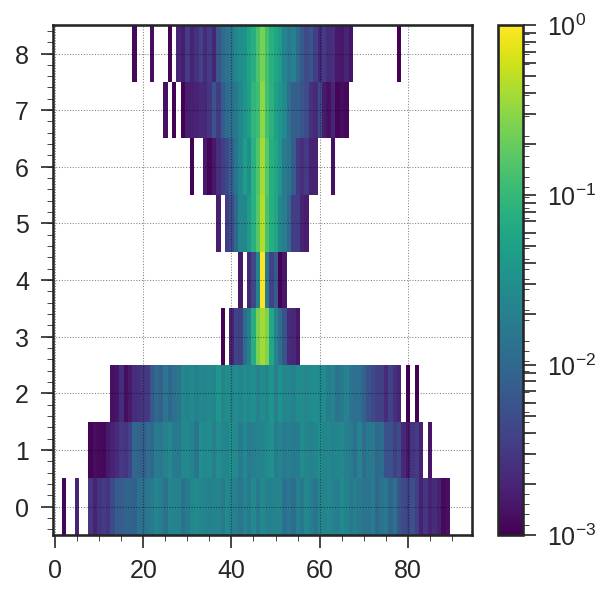

In [25]:
# plot results
draw_generated_images()

In [26]:
if do_training_allzones:
  
  for zone in xrange(nzones):
    print('Training model for zone%i' % zone)
    
    # load dataset
    x_train, x_test, y_train, y_test = load_dataset()

    # draw images
    draw_images()
    
    # create model
    encoder, decoder, model = create_model(original_dim=original_dim, interm_dim=interm_dim, latent_dim=latent_dim,
                                           learning_rate=learning_rate)

    # train model
    history = model.fit(x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, None))
    
    # save model
    save_my_model(model, get_model_name())
    save_my_model(encoder, get_model_name_enc())
    save_my_model(decoder, get_model_name_dec())
    
    # plot results
    submodels = (encoder, decoder)
    draw_generated_images()

In [27]:
### IGNORE THE FOLLOWING